Linear Regression using pytorch

Linear regression. We'll create a model that predicts crop yields for apples and oranges (target variables) by looking at the average temperature, rainfall and humidity (input variables or features) in a region. Here's the training data:

linear-regression-training-data

In a linear regression model, each target variable is estimated to be a weighted sum of the input variables, offset by some constant, known as a bias :

yield_apple  = w11 * temp + w12 * rainfall + w13 * humidity + b1
yield_orange = w21 * temp + w22 * rainfall + w23 * humidity + b2
Visually, it means that the yield of apples is a linear or planar function of temperature, rainfall and humidity:

linear-regression-graph

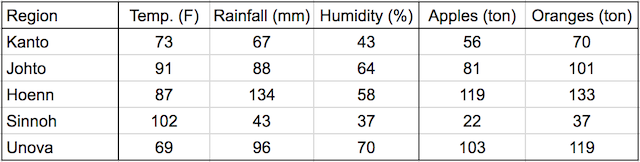

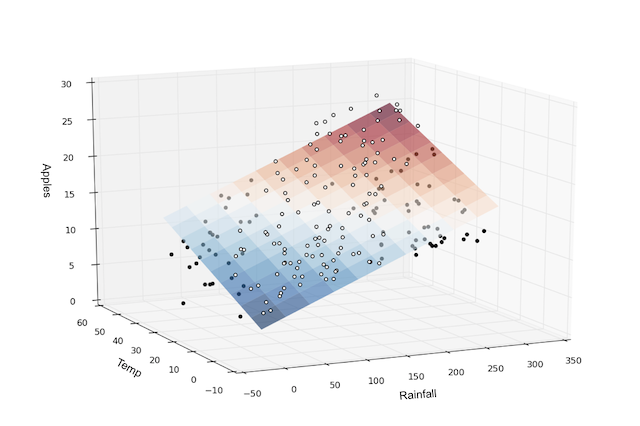

In [26]:
import numpy as np
import torch

In [27]:
input = np.array([[73, 67, 43],
                   [91, 88, 64],
                   [87, 134, 58],
                   [102, 43, 37],
                   [69, 96, 70]],dtype = 'float32')

In [28]:
target = np.array([[56, 70],
                    [81, 101],
                    [119, 133],
                    [22, 37],
                    [103, 119]], dtype='float32')

we will initialize weights and biases with random numbers so that we can do matrix multiplication

In [29]:
input = torch.from_numpy(input)
target = torch.from_numpy(target)

we will create matrix for weights and bias with random numbers to set initially

In [30]:
w = torch.randn(2,3,requires_grad = True)
b = torch.randn(2,requires_grad = True)
print(w)
print(b)
w.dtype

tensor([[-1.0052,  1.2857,  0.3687],
        [-1.9703, -0.2297, -1.5323]], requires_grad=True)
tensor([ 0.7138, -0.7581], requires_grad=True)


torch.float32

this creates a tensor , we use this so that we can get all the predictions due to all the inputs in one time , rather than using a loop or something to calculate all

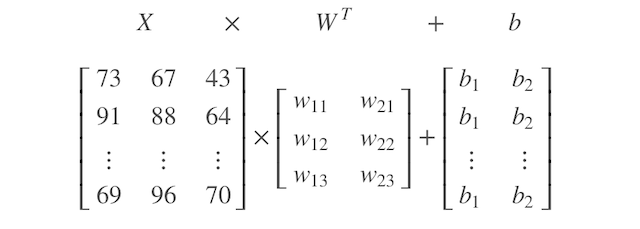

**@ represents matrix multiplication and .t() represents transpose of the matrix in pytorch**

In [31]:
def model(x):
    return x @ w.t() + b

In [32]:
preds = model(input)

In [33]:
print(preds)
print(target)

tensor([[  29.3307, -225.8677],
        [  45.9802, -298.3352],
        [ 106.9319, -291.8260],
        [ -32.8910, -268.2989],
        [  80.5937, -266.0209]], grad_fn=<AddBackward0>)
tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])


now if we look they are way too off the prediction and the target this is due to the weights and biases being random 

****LOSS FUNCTION****

we will use mse here 

In [34]:
diff = preds - target
torch.sum(diff*diff) / diff.numel()
print(diff)

tensor([[ -26.6693, -295.8677],
        [ -35.0198, -399.3352],
        [ -12.0681, -424.8260],
        [ -54.8910, -305.2989],
        [ -22.4063, -385.0209]], grad_fn=<SubBackward0>)


**numel to calculate the total number of elements in the tensor**

In [35]:
def mse(pred,target):
    diff = pred - target
    return torch.sum(diff*diff) / diff.numel()

In [36]:
print(mse(preds,target))

tensor(67453.0234, grad_fn=<DivBackward0>)


now we will try to minimize the loss function using gradient descent formula , but for that we need to calculate partial differentiation of loss function wrt w and b so that we can change w and b according to the minimal loss , we can use backward() function now with loss function this will calculate the diff of loss function wrt all the variables we had set requires_grad = true

In [37]:
loss = mse(preds,target)
print(loss)

tensor(67453.0234, grad_fn=<DivBackward0>)


In [38]:
loss.backward()

In [39]:
print(w.grad)
print(b.grad)

tensor([[ -2665.6992,  -2199.4048,  -1537.4801],
        [-30520.9297, -32396.2344, -20233.4375]])
tensor([ -30.2109, -362.0697])


.grad provides partial differention of it with the functoin used with backward

loss is a quadratic function meaning we can find a minima , we will plot loss function vs each individual weights or bias vs it and then move the weight of bias to a point where the loss function is minimum using the algorithm  of gradient descent 

If a gradient element is positive:

increasing the element's value slightly will increase the loss.
decreasing the element's value slightly will decrease the loss

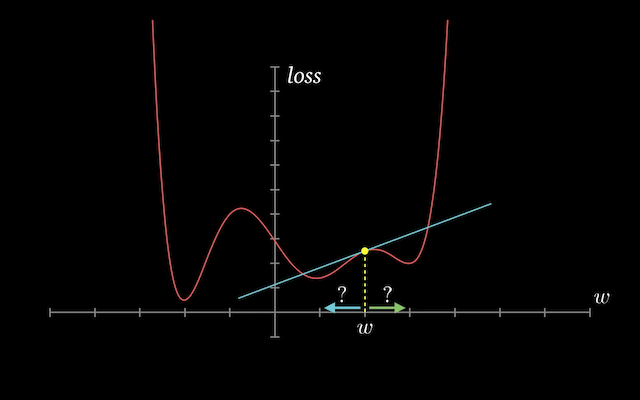

If a gradient element is negative:

increasing the element's value slightly will decrease the loss.
decreasing the element's value slightly will increase the loss.

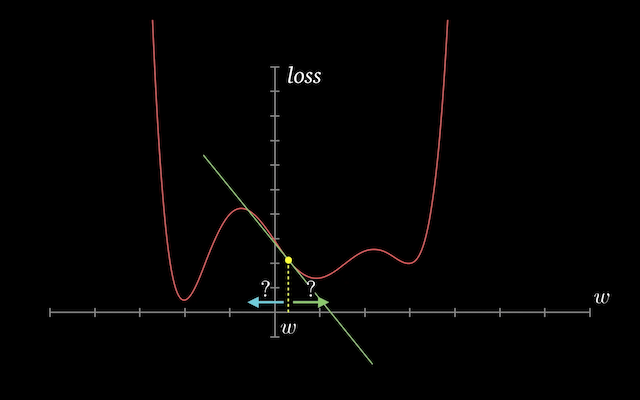

In [40]:
w -= w.grad * 1e-5
b -=b.grad*1e-5

RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.

### ⚠️ Note on Leaf Variable In-Place Error

In PyTorch, a **leaf tensor** is one you create directly with `requires_grad=True` (e.g., `w = torch.randn(3, requires_grad=True)`). If you try to update such a tensor with an **in-place operation** like `w -= w.grad * 1e-5`, you’ll get the error *"a leaf Variable that requires grad is being used in an in-place operation"* because the autograd engine needs the original values of leaf tensors to compute gradients and in-place modification breaks this tracking. ✅ To fix this, wrap your manual updates inside `torch.no_grad()`, which disables gradient tracking and allows safe parameter updates without interfering with autograd, for example:  
```python
with torch.no_grad():
    w -= w.grad * 1e-5
    b -= b.grad * 1e-5

also we are done with all the gradients now so we can use no_grad

In [43]:
with torch.no_grad():
    w -= w.grad * 1e-5
    b -=b.grad*1e-5
    w.grad.zero_()
    b.grad.zero_()

here 1e-5 is the learning rate

In [44]:
loss = mse(model(input),target)
print(loss)

tensor(27968.5430, grad_fn=<DivBackward0>)


 Why Gradients Accumulate
- In PyTorch, when you call loss.backward(), the computed gradients are added to the .grad attribute of each parameter.
- This accumulation is intentional: it allows flexibility (e.g., summing gradients across multiple mini-batches or sequences in RNNs).
- But in most training scenarios, you want fresh gradients for each batch → hence the need to reset them.
using grad_zero() function

### 🔒 `torch.no_grad()` in PyTorch

**Use Case:**  
`torch.no_grad()` is used when we **don’t want PyTorch to track operations** for automatic differentiation.  
Normally, when a tensor has `requires_grad=True`, PyTorch builds a computation graph to calculate gradients during backpropagation.  
However, inside a `with torch.no_grad():` block, **no computation graph is created**, even if the tensors have `requires_grad=True`.

**What Happens If We Change Values Inside `no_grad()`:**  
- The **values** of tensors with `requires_grad=True` **can still be changed**.  
- But since gradient tracking is **disabled**, those changes **won’t be recorded** in the computation graph.  
- As a result, **no gradients** will be computed for those operations in the next backward pass.

**Why Use It:**  
- To **update or modify parameters manually** (e.g., during evaluation or inference) **without affecting gradients**.  
- To **save memory and computation time**, since gradient tracking is turned off.

**Example:**
```python
import torch

x = torch.tensor([2.0], requires_grad=True)

with torch.no_grad():
    x += 3  # modifies x, but no gradient is tracked

print(x)             # tensor([5.])
print(x.requires_grad)  # True — but change wasn’t tracked


In [45]:
#now we train for 100 epochs to reduce the loss function
for i in range(100):
    preds = model(input)
    loss = mse(preds,target)
    loss.backward()
    with torch.no_grad():
        w-=w.grad*1e-5
        b-=b.grad*1e-5
        w.grad.zero_()
        b.grad.zero_()


In [46]:
print(mse(model(input),target))

tensor(148.2319, grad_fn=<DivBackward0>)


the loss from 68k is reduced to 148 , crazy enough right 

In [47]:
print(preds)

tensor([[ 54.5585,  69.6202],
        [ 77.9118,  90.1905],
        [132.6543, 157.8977],
        [  4.9794,  32.7192],
        [103.9862, 103.2683]], grad_fn=<AddBackward0>)


In [48]:
print(target)

tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])
